In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
from pathlib import Path
#Plotting

from waterfall_ax import WaterfallChart
import matplotlib.pyplot as plt


In [2]:
#Define the working directory
dir_path = "../Data"
#File names for import
revenue_file = Path(dir_path, "revenue_only.csv")
forecast_file = Path(dir_path, "forecast_country.csv")

In [3]:
# Selector

#Select the commercial sampels
#all_commercial = all_data[all_data["Type"] == "Commercial"]
quarter = "Q4 2023"
persona = "Country"
Month_into_quarter = 2
time_month = 3
gap_analyis_period = Month_into_quarter/time_month
cut_off_date = "2023-11-29"

#Q4_2023_forecast = forecast_data.loc[(forecast_data["Time"] == quarter) & (forecast_data["Forecaster"] == persona)]

In [4]:
#Read in all the data
all_data = pd.read_csv(all_data_file)
revenue_data = pd.read_csv(revenue_file)
forecast_data = pd.read_csv(forecast_file)
forecast_data["Country"] = forecast_data["Country"].replace({"Rest":'Rest-EU'})
forecast_data = forecast_data.rename(columns={"Volume":"Forecast"})


In [5]:
#Select the time periode and the forecaster for the analysis 
Q4_2023_forecast = forecast_data.loc[(forecast_data["Time"] == quarter) & (forecast_data["Forecaster"] == persona)]

In [6]:
Q4_2023_forecast.shape

(32, 7)

In [7]:
Q4_2023_forecast.head(5)

,Forecaster,Country,Time,Product,5QRF_Starting_Quarter,ASP,Forecast
12,Country,Canada,Q4 2023,G360 CDx,Q4_23,1200,25
13,Country,Canada,Q4 2023,G360 Infinity,Q4_23,1500,7
14,Country,Canada,Q4 2023,Reveal,Q4_23,1200,10
15,Country,Canada,Q4 2023,Shield,Q4_23,0,0
72,Country,Spain,Q4 2023,G360 CDx,Q4_23,1600,45


In [8]:
#all_commercial = all_data[all_data["Type"] == "Commercial"]
#Q4_2023_forecast = forecast_data.loc[(forecast_data["Time"] == quarter) & (forecast_data["Forecaster"] == persona)]

In [9]:
#Dict for correcting the country names
country_dict = {'CANADA': 'Canada',
 'SPAIN': 'Spain',
 'ITALY': 'Italy',
 'URUGUAY': 'Latam',
 'BRAZIL': 'Latam',
 'ARGENTINA': 'Latam',
 'HUNGARY': 'Rest-EU',
 'UNITED KINGDOM': 'UK',
 'MEXICO': 'Latam',
 'BELGIUM': 'Rest-EU',
 'TURKEY': 'Turkey',
 'COLOMBIA': 'Latam',
 'PERU': 'Latam',
 'FRANCE': 'France',
 'GERMANY': 'Rest-EU',
 'PORTUGAL': 'Rest-EU',
 'SWITZERLAND': 'Rest-EU',
 'COSTA RICA': 'Latam',
 'CHILE': 'Latam',
 'SWEDEN': 'Rest-EU',
 'NETHERLANDS': 'Rest-EU',
 'DENMARK': 'Rest-EU',
 'IRELAND': 'Rest-EU',
 'GREECE': 'Rest-EU',
 'AUSTRIA': 'Rest-EU',
 'CZECH REPUBLIC': 'Rest-EU',
 'CROATIA': 'Rest-EU',
 'UKRAINE': 'Rest-EU',
 'SLOVENIA': 'Rest-EU',
 'RUSSIA': 'Rest-EU',
 'BELARUS': 'Rest-EU',
 'FINLAND': 'Rest-EU',
 'PUERTO RICO': 'Latam',
 'LITHUANIA': 'Rest-EU',
 'NORTH MACEDONIA': 'Rest-EU',
 'ROMANIA': 'Rest-EU',
 'LUXEMBOURG': 'Rest-EU',
 'POLAND': 'Rest-EU'}

 

In [10]:
#Re-cast the product names to match the other df
product_dict = {"Guardant360 CDx": "G360 CDx", "G360/2.12": "G360 Infinity","Reveal":"Reveal" }

In [11]:
#Define function that transforms to same data format
def forecast_periode(data):
    data = " ".join([data[4:], data[0:4]])
    return data

#all_data = all_data["Quarter_Year"].map(forecast_periode)
all_data["Forecast_Region"] = all_data["Reporting Country"].map(country_dict)
#Cast the time period to be in the correct data format
all_data["Quarter_Year"] = all_data["Quarter_Year"].map(forecast_periode)


In [12]:
all_data.tail()

,Reporting Country ↑,Date Received,Accession #,Request Type,Account: Account Name,Contact: Full Name,Test Ordered,Sample Gene Panel,LIMS Project ID,Billing Type,Cancer Type,Final Report Date,Latest Report Date,Reporting Country,Type,Cancer Type_mapped,Reporting Country_mapped,Product,AE_supported,Currency,Sub_region,Month,Year,Quarter,Sales,Year_Month,Month_to_match,new LIMS Project ID,Quarter_Year,adv_Sub_region,Forecast_Region
20911,UY,2023-08-21,A0832101,Clinical,Practice Dr Luis Ubillos,Luis Ubillos,Guardant 360,2.11,GHI_01,Self-Pay Patient,Ovarian carcinoma,8/25/2023,8/25/2023,URUGUAY,Commercial,NaN,URUGUAY,1,non_AE,USD,Americas,8,2023,3,1,2023-08-01,2023-8,Guardant360 CDx,Q3 2023,South America,Latam
20912,UY,2023-09-25,A0858523,Clinical,Practice Dr Luis Ubillos,Luis Ubillos,83-Gene Panel,2.12,GH2_12,Self-Pay Patient,Prostate adenocarcinoma,10/2/2023,10/2/2023,URUGUAY,Commercial,NaN,URUGUAY,1,non_AE,USD,Americas,9,2023,3,1,2023-09-01,2023-9,G360/2.12,Q3 2023,South America,Latam
20913,UY,2023-03-20,A0690872,Clinical,Practice Dr Luis Ubillos,Luis Ubillos,Guardant 360,2.11,GHI_01,Self-Pay Patient,Breast Carcinoma,3/24/2023,3/24/2023,URUGUAY,Commercial,Breast,URUGUAY,1,non_AE,USD,Americas,3,2023,1,1,2023-03-01,2023-3,Guardant360 CDx,Q1 2023,South America,Latam
20914,UY,2023-02-06,A0660455,Clinical,Practice Dr Luis Ubillos,Luis Ubillos,Guardant 360,2.11,GHI_01,Self-Pay Patient,Pancreatic ductal adenocarcinoma,2/15/2023,2/16/2023,URUGUAY,Commercial,NaN,URUGUAY,1,non_AE,USD,Americas,2,2023,1,1,2023-02-01,2023-2,Guardant360 CDx,Q1 2023,South America,Latam
20915,UY,2023-07-26,A0809880,Clinical,Practice Dr Luis Ubillos,Luis Ubillos,Guardant 360,2.11,GHI_01,Self-Pay Patient,Lung adenocarcinoma,7/31/2023,7/31/2023,URUGUAY,Commercial,NaN,URUGUAY,1,non_AE,USD,Americas,7,2023,3,1,2023-07-01,2023-7,Guardant360 CDx,Q3 2023,South America,Latam


In [13]:
all_data["new LIMS Project ID"].value_counts()

new LIMS Project ID
Guardant360 CDx    5455
G360/2.12           342
Reveal               63
Name: count, dtype: int64

In [14]:
#Clean up the data set
all_data["Date Received"] = pd.to_datetime(all_data["Date Received"])
all_data = all_data.set_index("Date Received")
all_data = all_data.drop(columns=["Product"], axis = 1)
all_data = all_data.rename(columns={"Reporting Country  ↑":"Country", "new LIMS Project ID":"Product", "Quarter_Year":"Time", 'Sales':"Actuals"})
all_data = all_data[["Forecast_Region","Time", "Product", "Type" , "Actuals"]]
all_data = all_data.sort_index()


In [15]:
#Select the data until the cut off date
all_data = all_data.loc[:cut_off_date ]
all_data

,Forecast_Region,Time,Product,Type,Actuals
Date Received,,,,,
2020-01-02,UK,Q1 2020,Guardant360 CDx,Commercial,1
2020-01-02,UK,Q1 2020,NaN,Biopharma,1
2020-01-02,UK,Q1 2020,Guardant360 CDx,Commercial,1
2020-01-02,Spain,Q1 2020,NaN,GAP,1
2020-01-02,UK,Q1 2020,NaN,GAP,1
...,...,...,...,...,...
2023-11-29,Spain,Q4 2023,NaN,ISTs,1
2023-11-29,Italy,Q4 2023,NaN,Biopharma,1
2023-11-29,Rest-EU,Q4 2023,NaN,Biopharma,1


In [16]:
#Check the cut of date
print(f"The most recent date in the dataset is {all_data.index.max()}")

The most recent date in the dataset is 2023-11-29 00:00:00


In [17]:
#Select just the Commercial cases
all_commercial = all_data[all_data["Type"] == "Commercial"]
all_commercial.sort_index().tail(10)

,Forecast_Region,Time,Product,Type,Actuals
Date Received,,,,,
2023-11-27,Italy,Q4 2023,Guardant360 CDx,Commercial,1
2023-11-27,Turkey,Q4 2023,G360/2.12,Commercial,1
2023-11-27,Italy,Q4 2023,Guardant360 CDx,Commercial,1
2023-11-28,Turkey,Q4 2023,G360/2.12,Commercial,1
2023-11-28,UK,Q4 2023,Guardant360 CDx,Commercial,1
2023-11-29,UK,Q4 2023,Guardant360 CDx,Commercial,1
2023-11-29,UK,Q4 2023,G360/2.12,Commercial,1
2023-11-29,Turkey,Q4 2023,G360/2.12,Commercial,1
2023-11-29,Spain,Q4 2023,Guardant360 CDx,Commercial,1


In [18]:
#test
all_commercial[all_commercial["Time"] == "Q4 2023"]

,Forecast_Region,Time,Product,Type,Actuals
Date Received,,,,,
2023-10-02,UK,Q4 2023,Guardant360 CDx,Commercial,1
2023-10-02,Italy,Q4 2023,Guardant360 CDx,Commercial,1
2023-10-02,UK,Q4 2023,Guardant360 CDx,Commercial,1
2023-10-02,Spain,Q4 2023,Guardant360 CDx,Commercial,1
2023-10-02,Latam,Q4 2023,Guardant360 CDx,Commercial,1
...,...,...,...,...,...
2023-11-29,UK,Q4 2023,Guardant360 CDx,Commercial,1
2023-11-29,UK,Q4 2023,G360/2.12,Commercial,1
2023-11-29,Turkey,Q4 2023,G360/2.12,Commercial,1


In [19]:
#Group the sales data by country, quarter and product
commercial_grouped = all_commercial.groupby(["Forecast_Region","Time", "Product"])["Actuals"].sum().reset_index()
commercial_grouped = commercial_grouped.rename(columns={"Forecast_Region":"Country"})
commercial_grouped["Product"] = commercial_grouped["Product"].map(product_dict)
commercial_grouped.sample(5)

,Country,Time,Product,Actuals
133,Turkey,Q3 2021,G360 CDx,24
44,Italy,Q2 2023,G360 CDx,21
88,Rest-EU,Q3 2023,G360 CDx,4
86,Rest-EU,Q3 2022,G360 CDx,10
166,UK,Q4 2021,G360 CDx,132


In [20]:
#Plot the forecast data structure
Q4_2023_forecast.sample(5)

,Forecaster,Country,Time,Product,5QRF_Starting_Quarter,ASP,Forecast
434,Country,France,Q4 2023,Reveal,Q4_23,0,0
374,Country,Rest-EU,Q4 2023,Reveal,Q4_23,0,0
252,Country,Latam,Q4 2023,G360 CDx,Q4_23,1900,54
432,Country,France,Q4 2023,G360 CDx,Q4_23,1100,5
315,Country,Italy,Q4 2023,Shield,Q4_23,0,0


In [21]:
#Add the actual results to the forecast dataframe by merging both df
results = pd.merge(Q4_2023_forecast, commercial_grouped, how = "left", on=["Country", "Time", "Product"])

results.sample(2)

,Forecaster,Country,Time,Product,5QRF_Starting_Quarter,ASP,Forecast,Actuals
2,Country,Canada,Q4 2023,Reveal,Q4_23,1200,10,NaN
30,Country,France,Q4 2023,Reveal,Q4_23,0,0,NaN


In [22]:
#Fill na with 0's
results = results.fillna(0,axis = 1)
results.sample(2)

,Forecaster,Country,Time,Product,5QRF_Starting_Quarter,ASP,Forecast,Actuals
15,Country,Turkey,Q4 2023,Shield,Q4_23,0,0,0
9,Country,UK,Q4 2023,G360 Infinity,Q4_23,3000,5,5.0


In [23]:
#Calculate the forecast for the analysis periode and calculate the difference
results["Actuals"] = results["Actuals"].astype(int)
results["Temp_Forecast"] = (results["Forecast"]*gap_analyis_period).astype(float).round(0)
results["Forecast_gap"] = results["Actuals"] - results["Temp_Forecast"]




In [24]:
results


,Forecaster,Country,Time,Product,5QRF_Starting_Quarter,ASP,Forecast,Actuals,Temp_Forecast,Forecast_gap
0,Country,Canada,Q4 2023,G360 CDx,Q4_23,1200,25,4,17.0,-13.0
1,Country,Canada,Q4 2023,G360 Infinity,Q4_23,1500,7,6,5.0,1.0
2,Country,Canada,Q4 2023,Reveal,Q4_23,1200,10,0,7.0,-7.0
3,Country,Canada,Q4 2023,Shield,Q4_23,0,0,0,0.0,0.0
4,Country,Spain,Q4 2023,G360 CDx,Q4_23,1600,45,31,30.0,1.0
5,Country,Spain,Q4 2023,G360 Infinity,Q4_23,2000,5,4,3.0,1.0
6,Country,Spain,Q4 2023,Reveal,Q4_23,0,0,0,0.0,0.0
7,Country,Spain,Q4 2023,Shield,Q4_23,0,0,0,0.0,0.0
8,Country,UK,Q4 2023,G360 CDx,Q4_23,1545,132,207,88.0,119.0
9,Country,UK,Q4 2023,G360 Infinity,Q4_23,3000,5,5,3.0,2.0


In [84]:
columns = ["Forecast", "G360 CDx", "G360 Infinity","Reveal","Shield", "Forecast"]

def plot_country_waterfall(country):
    results_by_country = results[results["Country"]== country].reset_index(drop = True)
    #Set the waterfall column to be the absolute forecast gap for each product
    results_by_country["Waterfall"] = results_by_country["Forecast_gap"]
    result_list = results_by_country["Waterfall"].to_list()
    sum_temp_forecast = results_by_country["Temp_Forecast"].sum()
    result_list.insert(0,sum_temp_forecast)
    #result_list.insert(0,results_by_country._get_value(0,"Temp_Forecast"))
    temp_df = pd.Series(result_list)
    temp_df = temp_df.cumsum()
    result_list_final = temp_df.to_list()
    
    
    plt.style.use('dark_background')

    step_names = ["Forecast", "G360 CDx", "G360 Infinity","Reveal","Shield"]
# Plot
    waterfall = WaterfallChart(result_list_final, step_names=step_names)
    color_kwargs = {
    'c_bar_pos': 'lightgreen',
    'c_bar_neg': 'red',
    'c_bar_start': 'white',
    'c_bar_end': 'white',
    'c_text_pos': 'white',    
    'c_text_neg': 'white',
    'c_text_start': 'yellow',
    'c_text_end': 'yellow'
}
    wf_ax = waterfall.plot_waterfall(title=f'Gap Analysis for the { results_by_country.loc[0, "Country"] } ' , color_kwargs=color_kwargs)
    plt.savefig(f"../Plots/{country}.pdf")

/Users/mhausch/Data/Prod_Dashboards/venv/lib/python3.9/site-packages/waterfall_ax/waterfall_ax.py:121: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = '{:,}'.format(int(df_plot[self.delta_col][i]))
/Users/mhausch/Data/Prod_Dashboards/venv/lib/python3.9/site-packages/waterfall_ax/waterfall_ax.py:121: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = '{:,}'.format(int(df_plot[self.delta_col][i]))
/Users/mhausch/Data/Prod_Dashboards/venv/lib/python3.9/site-packages/waterfall_ax/waterfall_ax.py:121: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

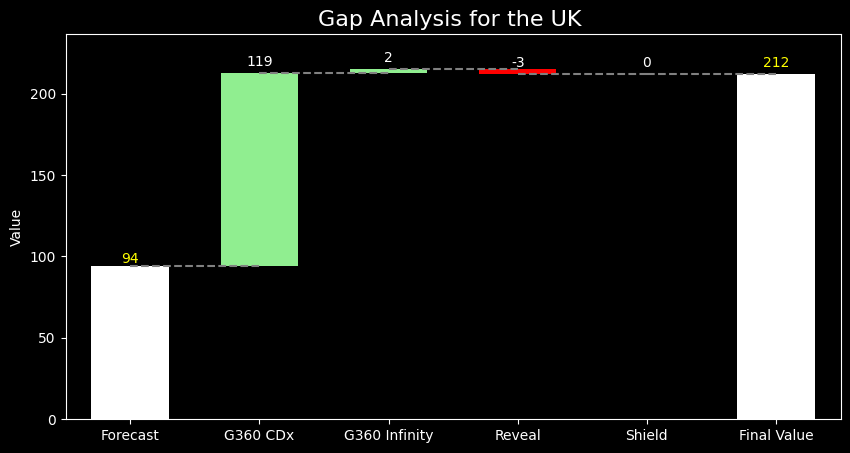

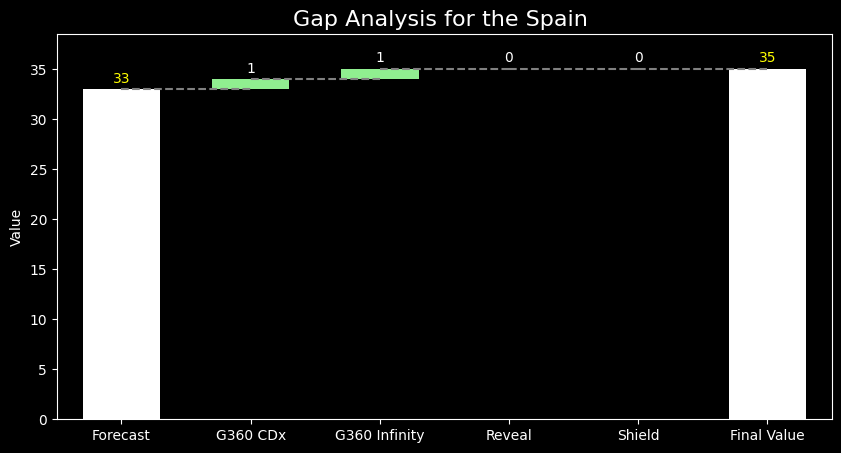

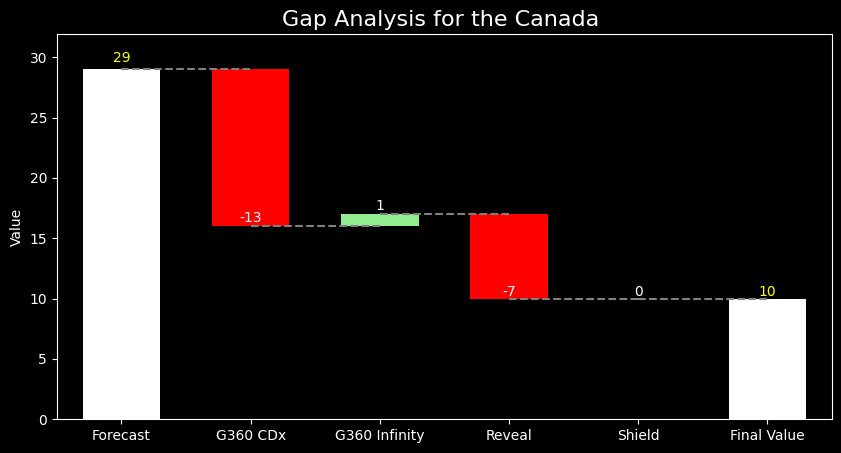

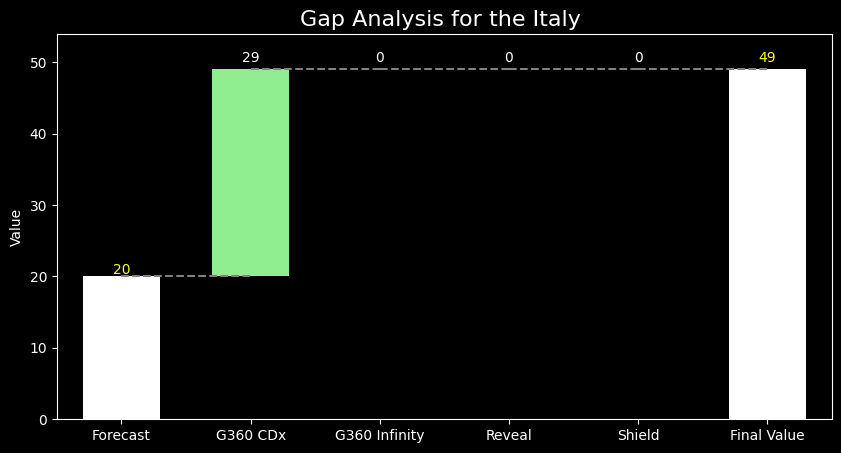

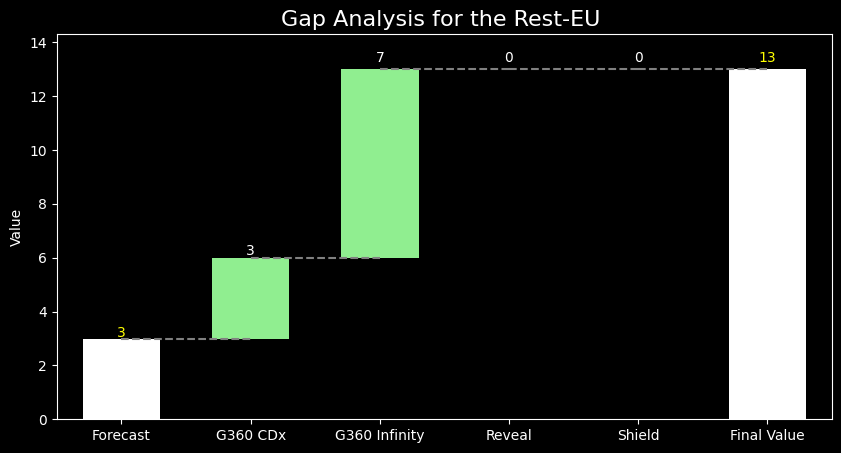

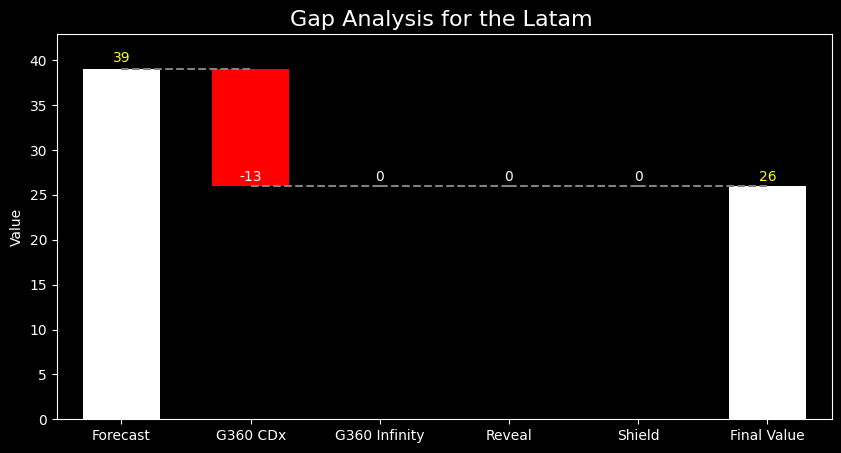

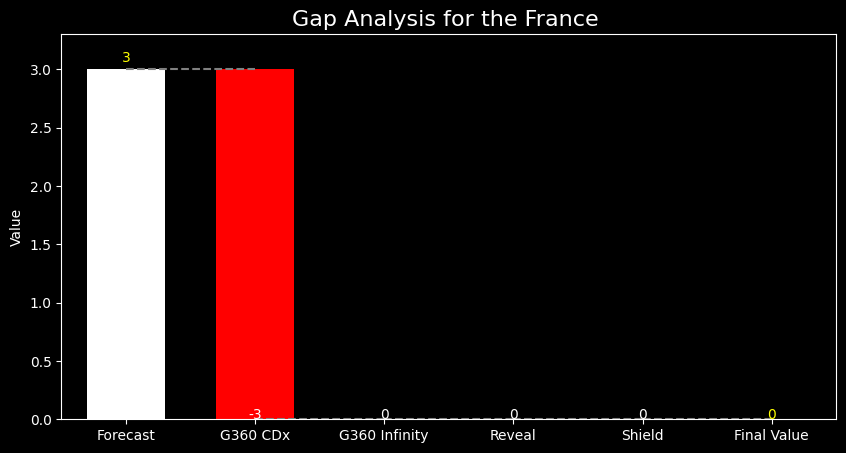

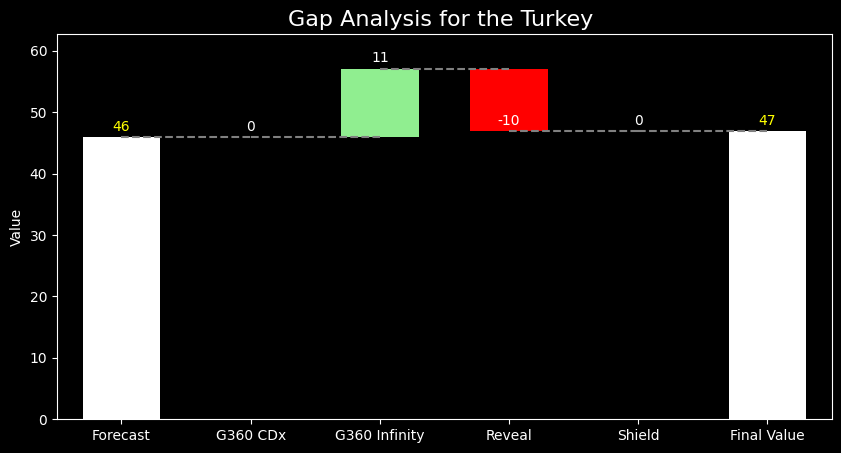

In [85]:
countries = ["UK", "Spain", "Canada", "Italy", "Rest-EU", "Latam", "France", 'Turkey']

for country in countries:
    plot_country_waterfall(country)
    

# Plot the gap analysis for EUAA vs countries

In [27]:
#Define the input dataframe

EUAA_forecast = forecast_data.copy()
EUAA_sales = all_data.copy()

In [28]:
EUAA_sales.sample(2)


,Forecast_Region,Time,Product,Type,Actuals
Date Received,,,,,
2023-06-14,Rest-EU,Q2 2023,NaN,Biopharma,1
2023-06-15,UK,Q2 2023,NaN,ISTs,1


In [29]:
print(f"The maximum date is {EUAA_sales.index.max()}")

The maximum date is 2023-11-29 00:00:00


In [30]:
# Selector

#Select the commercial sampels
EUAA_sales_commercial = EUAA_sales[EUAA_sales["Type"] == "Commercial"]
quarter = "Q4 2023"
persona = "Country"
temp = 3
Month_into_quarter = 1

In [31]:
EUAA_sales_commercial.to_csv("../Data/commercial_samples.csv", index=True)

In [32]:
#Groupby the country and time periode/quarter
EUAA_sales_commercial = EUAA_sales_commercial.groupby(["Forecast_Region", "Time"])["Actuals"].sum().reset_index()
#Select the time periode for analysis
EUAA_sales_commercial = EUAA_sales_commercial[EUAA_sales_commercial["Time"] == "Q4 2023"]
EUAA_sales_commercial = EUAA_sales_commercial.rename(columns={"Forecast_Region":"Country"})
EUAA_sales_commercial

,Country,Time,Actuals
15,Canada,Q4 2023,10
38,Italy,Q4 2023,49
54,Latam,Q4 2023,26
70,Rest-EU,Q4 2023,13
86,Spain,Q4 2023,35
102,Turkey,Q4 2023,47
118,UK,Q4 2023,212


In [33]:
#Select the time periode for the analysis
EUAA_forecast_filtered = EUAA_forecast.loc[(EUAA_forecast["Time"] == quarter) & (EUAA_forecast["Forecaster"] == persona)]

EUAA_forecast_filtered = EUAA_forecast_filtered.groupby(["Country"])["Forecast"].sum().reset_index()
EUAA_forecast_filtered

,Country,Forecast
0,Canada,42
1,France,5
2,Italy,30
3,Latam,59
4,Rest-EU,5
5,Spain,50
6,Turkey,70
7,UK,142


In [34]:
EUAA_forecast_filtered

,Country,Forecast
0,Canada,42
1,France,5
2,Italy,30
3,Latam,59
4,Rest-EU,5
5,Spain,50
6,Turkey,70
7,UK,142


In [35]:
#Create the results dataframe
EUAA_results = pd.merge(EUAA_forecast_filtered, EUAA_sales_commercial, how = "left", on=["Country"])
EUAA_results = EUAA_results.fillna(0,axis = 1)
EUAA_results["Actuals"] = EUAA_results["Actuals"].astype(int)
EUAA_results["Temp_Forecast"] = (EUAA_results["Forecast"]*gap_analyis_period).astype(float).round(0)
EUAA_results["Forecast_gap"] = EUAA_results["Actuals"] - EUAA_results["Temp_Forecast"]

In [36]:
EUAA_results

,Country,Forecast,Time,Actuals,Temp_Forecast,Forecast_gap
0,Canada,42,Q4 2023,10,28.0,-18.0
1,France,5,0,0,3.0,-3.0
2,Italy,30,Q4 2023,49,20.0,29.0
3,Latam,59,Q4 2023,26,39.0,-13.0
4,Rest-EU,5,Q4 2023,13,3.0,10.0
5,Spain,50,Q4 2023,35,33.0,2.0
6,Turkey,70,Q4 2023,47,47.0,0.0
7,UK,142,Q4 2023,212,95.0,117.0


In [37]:
#Calculate the sum of the forecast gap
sum_temp_forcast =EUAA_results["Temp_Forecast"].sum()
sum_temp_forcast

268.0

In [38]:
country_list = EUAA_results["Country"].to_list()
country_list.insert(0, "Forecast")
country_list

['Forecast',
 'Canada',
 'France',
 'Italy',
 'Latam',
 'Rest-EU',
 'Spain',
 'Turkey',
 'UK']

In [39]:
print(country_list)

['Forecast', 'Canada', 'France', 'Italy', 'Latam', 'Rest-EU', 'Spain', 'Turkey', 'UK']


In [40]:
EUAA_results_list = EUAA_results["Forecast_gap"].to_list()

In [41]:
EUAA_results_list

[-18.0, -3.0, 29.0, -13.0, 10.0, 2.0, 0.0, 117.0]

In [42]:
EUAA_results_list.insert(0,sum_temp_forcast)
#result_list.insert(0,results_by_country._get_value(0,"Temp_Forecast"))
EUAA_temp_df = pd.Series(EUAA_results_list)
EUAA_temp_df = EUAA_temp_df.cumsum()
result_list_final = EUAA_temp_df.to_list()

In [43]:
result_list_final, len(result_list_final)

([268.0, 250.0, 247.0, 276.0, 263.0, 273.0, 275.0, 275.0, 392.0], 9)

/Users/mhausch/Data/Prod_Dashboards/venv/lib/python3.9/site-packages/waterfall_ax/waterfall_ax.py:121: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = '{:,}'.format(int(df_plot[self.delta_col][i]))


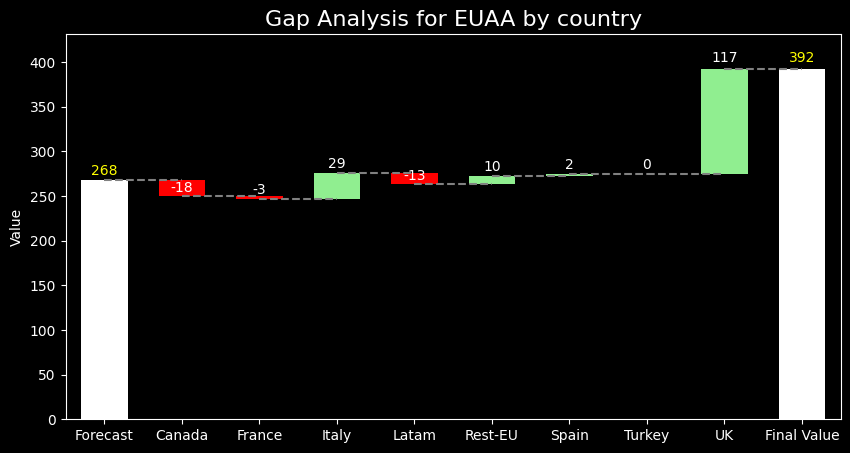

In [44]:
waterfall_EUAA = WaterfallChart(result_list_final, step_names=country_list)
color_kwargs = {
'c_bar_pos': 'lightgreen',
'c_bar_neg': 'red',
'c_bar_start': 'white',
'c_bar_end': 'white',
'c_text_pos': 'white',    
    'c_text_neg': 'white',
    'c_text_start': 'yellow',
    'c_text_end': 'yellow'}
wf_ax = waterfall_EUAA.plot_waterfall(title=f'Gap Analysis for EUAA by country' , color_kwargs=color_kwargs)
plt.savefig(f"EUAA_gap_analysis.pdf")

### EUAA gap analysis by Product

In [45]:
EUAA_forecast = forecast_data.copy()
EUAA_sales = all_data.copy()

In [46]:
EUAA_forecast.head(3)

,Forecaster,Country,Time,Product,5QRF_Starting_Quarter,ASP,Forecast
0,Country,Canada,Q1 2024,G360 CDx,Q4_23,1450,30
1,Country,Canada,Q1 2024,G360 Infinity,Q4_23,1700,9
2,Country,Canada,Q1 2024,Reveal,Q4_23,1700,10


In [47]:
EUAA_sales.head(3)

,Forecast_Region,Time,Product,Type,Actuals
Date Received,,,,,
2020-01-02,UK,Q1 2020,Guardant360 CDx,Commercial,1
2020-01-02,UK,Q1 2020,NaN,Biopharma,1
2020-01-02,UK,Q1 2020,Guardant360 CDx,Commercial,1


In [48]:
#Select the commercial sampels
EUAA_sales_commercial = EUAA_sales[EUAA_sales["Type"] == "Commercial"]
quarter = "Q4 2023"
persona = "Country"
temp = 3
Month_into_quarter = 1

In [68]:
#Create the sales dataframe for the gap analysis
EUAA_gap_product_input = EUAA_sales[EUAA_sales["Time"] == "Q4 2023"]
EUAA_gap_product_input = EUAA_gap_product_input.groupby(["Product"])["Actuals"].sum().reset_index()
EUAA_gap_product_input = EUAA_gap_product_input.rename(columns={"Forecast_Region":"Country"})
EUAA_gap_product_input["Product"] = EUAA_gap_product_input["Product"].map(product_dict)
EUAA_gap_product_input

,Product,Actuals
0,G360 Infinity,59
1,G360 CDx,333
2,Reveal,3


In [69]:
#Create the forecast dataframe for the gap analysis
EUAA_gap_product_forecast = EUAA_forecast.loc[(EUAA_forecast["Time"] == quarter) & (EUAA_forecast["Forecaster"] == persona)]
EUAA_gap_product_forecast = EUAA_gap_product_forecast.groupby(["Product"])["Forecast"].sum().reset_index()
EUAA_gap_product_forecast

,Product,Forecast
0,G360 CDx,316
1,G360 Infinity,57
2,Reveal,30
3,Shield,0


In [70]:
EUAA_gap_product_forecast = pd.merge(EUAA_gap_product_input, EUAA_gap_product_forecast, how = "left", on=["Product"])
EUAA_gap_product_forecast

,Product,Actuals,Forecast
0,G360 Infinity,59,57
1,G360 CDx,333,316
2,Reveal,3,30


In [71]:
EUAA_gap_product_forecast = EUAA_gap_product_forecast.fillna(0,axis = 1)
EUAA_gap_product_forecast["Actuals"] = EUAA_gap_product_forecast["Actuals"].astype(int)
EUAA_gap_product_forecast["Temp_Forecast"] = (EUAA_gap_product_forecast["Forecast"]*gap_analyis_period).astype(float).round(0)
EUAA_gap_product_forecast["Forecast_gap"] = EUAA_gap_product_forecast["Actuals"] - EUAA_gap_product_forecast["Temp_Forecast"]

In [72]:
EUAA_gap_product_forecast

,Product,Actuals,Forecast,Temp_Forecast,Forecast_gap
0,G360 Infinity,59,57,38.0,21.0
1,G360 CDx,333,316,211.0,122.0
2,Reveal,3,30,20.0,-17.0


In [73]:
#Calculate the sum of the forecast gap
sum_temp_forcast_prod =EUAA_gap_product_forecast["Temp_Forecast"].sum()
sum_temp_forcast_prod 


269.0

In [74]:
prod_list = EUAA_gap_product_forecast["Product"].to_list()
prod_list.insert(0, "Forecast")
prod_list

['Forecast', 'G360 Infinity', 'G360 CDx', 'Reveal']

In [75]:
EUAA_results_list_prod = EUAA_gap_product_forecast["Forecast_gap"].to_list()
EUAA_results_list_prod.insert(0,sum_temp_forcast_prod)

In [76]:
EUAA_results_list_prod

[269.0, 21.0, 122.0, -17.0]

In [77]:
EUAA_temp_df_prod = pd.Series(EUAA_results_list_prod)
EUAA_temp_df_prod = EUAA_temp_df_prod.cumsum()
result_list_final_prod = EUAA_temp_df_prod.to_list()

In [78]:
result_list_final_prod

[269.0, 290.0, 412.0, 395.0]

In [79]:
step_names_EUAA_by_product = EUAA_gap_product_forecast["Product"].to_list()
step_names_EUAA_by_product

['G360 Infinity', 'G360 CDx', 'Reveal']

/Users/mhausch/Data/Prod_Dashboards/venv/lib/python3.9/site-packages/waterfall_ax/waterfall_ax.py:121: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = '{:,}'.format(int(df_plot[self.delta_col][i]))


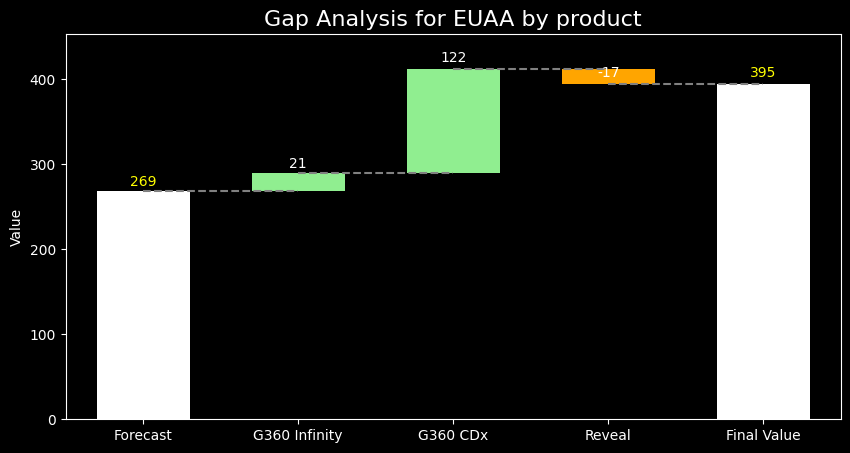

In [80]:
waterfall_EUAA = WaterfallChart(result_list_final_prod,step_names= prod_list )
color_kwargs = {
'c_bar_pos': 'lightgreen',
'c_bar_neg': 'orange',
'c_bar_start': 'white',
'c_bar_end': 'white',
'c_text_pos': 'white',    
    'c_text_neg': 'white',
    'c_text_start': 'yellow',
    'c_text_end': 'yellow'}
wf_ax = waterfall_EUAA.plot_waterfall(title=f'Gap Analysis for EUAA by product' , color_kwargs=color_kwargs)
plt.savefig(f"EUAA_gap_analysis_by_product.pdf")